# Classification I: training & predicting {#classification}

In [1]:
import random

import altair as alt
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline

alt.data_transformers.disable_max_rows()
# # Handle large data sets by not embedding them in the notebook
alt.data_transformers.enable('data_server')

# # Save a PNG blob as a backup for when the Altair plots do not render
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Overview 
In previous chapters, we focused solely on descriptive and exploratory
data analysis questions. 
This chapter and the next together serve as our first
foray into answering *predictive* questions about data. In particular, we will
focus on *classification*, i.e., using one or more 
variables to predict the value of a categorical variable of interest. This chapter
will cover the basics of classification, how to preprocess data to make it
suitable for use in a classifier, and how to use our observed data to make
predictions. The next chapter will focus on how to evaluate how accurate the
predictions from our classifier are, as well as how to improve our classifier
(where possible) to maximize its accuracy.

## Chapter learning objectives 

By the end of the chapter, readers will be able to do the following:

- Recognize situations where a classifier would be appropriate for making predictions.
- Describe what a training data set is and how it is used in classification.
- Interpret the output of a classifier.
- Compute, by hand, the straight-line (Euclidean) distance between points on a graph when there are two predictor variables.
- Explain the $K$-nearest neighbor classification algorithm.
- Perform $K$-nearest neighbor classification in Python using `scikit-learn`.
- Use `StandardScaler` to preprocess data to be centered, scaled, and balanced.
- Combine preprocessing and model training using `make_pipeline`.

## The classification problem

In many situations, we want to make predictions \index{predictive question} based on the current situation
as well as past experiences. For instance, a doctor may want to diagnose a
patient as either diseased or healthy based on their symptoms and the doctor's
past experience with patients; an email provider might want to tag a given
email as "spam" or "not spam" based on the email's text and past email text data; 
or a credit card company may want to predict whether a purchase is fraudulent based
on the current purchase item, amount, and location as well as past purchases.
These tasks are all examples of \index{classification} **classification**, i.e., predicting a
categorical class (sometimes called a *label*) \index{class}\index{categorical variable} for an observation given its
other variables (sometimes called *features*). \index{feature|see{predictor}}

Generally, a classifier assigns an observation without a known class (e.g., a new patient) 
to a class (e.g., diseased or healthy) on the basis of how similar it is to other observations
for which we do know the class (e.g., previous patients with known diseases and
symptoms). These observations with known classes that we use as a basis for
prediction are called a **training set**; \index{training set} this name comes from the fact that
we use these data to train, or teach, our classifier. Once taught, we can use
the classifier to make predictions on new data for which we do not know the class.

There are many possible methods that we could use to predict
a categorical class/label for an observation. In this book, we will
focus on the widely used **$K$-nearest neighbors** \index{K-nearest neighbors} algorithm [@knnfix; @knncover].
In your future studies, you might encounter decision trees, support vector machines (SVMs),
logistic regression, neural networks, and more; see the additional resources
section at the end of the next chapter for where to begin learning more about
these other methods. It is also worth mentioning that there are many
variations on the basic classification problem. For example, 
we focus on the setting of **binary classification** \index{classification!binary} where only two
classes are involved (e.g., a diagnosis of either healthy or diseased), but you may 
also run into multiclass classification problems with more than two
categories (e.g., a diagnosis of healthy, bronchitis, pneumonia, or a common cold).

## Exploring a data set

In this chapter and the next, we will study a data set of 
[digitized breast cancer image features](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29),
created by Dr. William H. Wolberg, W. Nick Street, and Olvi L. Mangasarian [@streetbreastcancer]. \index{breast cancer} 
Each row in the data set represents an
image of a tumor sample, including the diagnosis (benign or malignant) and
several other measurements (nucleus texture, perimeter, area, and more).
Diagnosis for each image was conducted by physicians. 

As with all data analyses, we first need to formulate a precise question that
we want to answer. Here, the question is *predictive*: \index{question!classification} can 
we use the tumor
image measurements available to us to predict whether a future tumor image
(with unknown diagnosis) shows a benign or malignant tumor? Answering this
question is important because traditional, non-data-driven methods for tumor
diagnosis are quite subjective and dependent upon how skilled and experienced
the diagnosing physician is. Furthermore, benign tumors are not normally
dangerous; the cells stay in the same place, and the tumor stops growing before
it gets very large. By contrast, in malignant tumors, the cells invade the
surrounding tissue and spread into nearby organs, where they can cause serious
damage [@stanfordhealthcare].
Thus, it is important to quickly and accurately diagnose the tumor type to
guide patient treatment.

### Loading the cancer data

Our first step is to load, wrangle, and explore the data using visualizations
in order to better understand the data we are working with. We start by
loading the `pandas` package needed for our analysis.

In [2]:
import pandas as pd

In this case, the file containing the breast cancer data set is a `.csv`
file with headers. We'll use the `read_csv` function with no additional
arguments, and then inspect its contents:

\index{read function!read\_csv}

In [3]:
cancer = pd.read_csv("data/wdbc.csv")
cancer

,ID,Class,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_Points,Symmetry,Fractal_Dimension
0,842302,M,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764
1,842517,M,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889
2,84300903,M,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658
3,84348301,M,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602
4,84358402,M,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956
...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209
565,926682,M,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681
566,926954,M,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800
567,927241,M,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778


### Describing the variables in the cancer data set

Breast tumors can be diagnosed by performing a *biopsy*, a process where
tissue is removed from the body and examined for the presence of disease.
Traditionally these procedures were quite invasive; modern methods such as fine
needle aspiration, used to collect the present data set, extract only a small
amount of tissue and are less invasive. Based on a digital image of each breast
tissue sample collected for this data set, ten different variables were measured
for each cell nucleus in the image (items 3&ndash;12 of the list of variables below), and then the mean 
 for each variable across the nuclei was recorded. As part of the
data preparation, these values have been *standardized (centered and scaled)*; we will discuss what this
means and why we do it later in this chapter. Each image additionally was given
a unique ID and a diagnosis by a physician.  Therefore, the
total set of variables per image in this data set is:

1. ID: identification number 
2. Class: the diagnosis (M = malignant or B = benign)
3. Radius: the mean of distances from center to points on the perimeter
4. Texture: the standard deviation of gray-scale values
5. Perimeter: the length of the surrounding contour 
6. Area: the area inside the contour
7. Smoothness: the local variation in radius lengths
8. Compactness: the ratio of squared perimeter and area
9. Concavity: severity of concave portions of the contour 
10. Concave Points: the number of concave portions of the contour
11. Symmetry: how similar the nucleus is when mirrored 
12. Fractal Dimension: a measurement of how "rough" the perimeter is

Below we use `.info()` \index{glimpse} to preview the data frame. This function can 
make it easier to inspect the data when we have a lot of columns, 
as it prints the data such that the columns go down 
the page (instead of across).

In [4]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 569 non-null    int64  
 1   Class              569 non-null    object 
 2   Radius             569 non-null    float64
 3   Texture            569 non-null    float64
 4   Perimeter          569 non-null    float64
 5   Area               569 non-null    float64
 6   Smoothness         569 non-null    float64
 7   Compactness        569 non-null    float64
 8   Concavity          569 non-null    float64
 9   Concave_Points     569 non-null    float64
 10  Symmetry           569 non-null    float64
 11  Fractal_Dimension  569 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 53.5+ KB


From the summary of the data above, we can see that `Class` is of type object.

In [5]:
# cancer <- cancer |>
#   mutate(Class = as_factor(Class))
# glimpse(cancer)

Given that we only have two different values in our `Class` column (B for benign and M 
for malignant), we only expect to get two names back.

In [6]:
cancer['Class'].unique()

array(['M', 'B'], dtype=object)

### Exploring the cancer data

Before we start doing any modeling, let's explore our data set. Below we use
the `groupby`, `count` methods to find the number and percentage 
of benign and malignant tumor observations in our data set. When paired with `groupby`, `count` counts the number of observations in each `Class` group. 
Then we calculate the percentage in each group by dividing by the total number of observations. We have 357 (63\%) benign and 212 (37\%) malignant tumor observations.

In [7]:
num_obs = len(cancer)
explore_cancer = pd.DataFrame()
explore_cancer['count'] = cancer.groupby('Class')['ID'].count()
explore_cancer['percentage'] = explore_cancer['count'] / num_obs * 100
explore_cancer

,count,percentage
Class,,
B,357,62.741652
M,212,37.258348


Next, let's draw a scatter plot \index{visualization!scatter} to visualize the relationship between the
perimeter and concavity variables. Rather than use `altair's` default palette,
we select our own colorblind-friendly colors&mdash;`"#efb13f"` 
for light orange and `"#86bfef"` for light blue&mdash;and
 pass them as the `scale` argument in the `color` argument. 
We also make the category labels ("B" and "M") more readable by 
changing them to "Benign" and "Malignant".

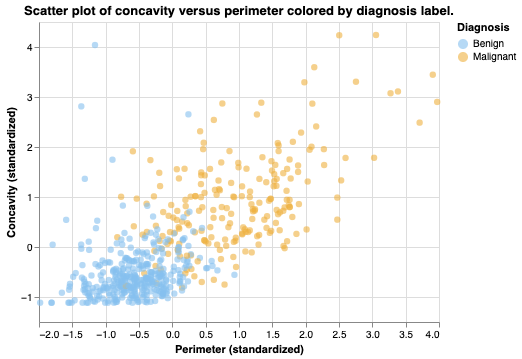

In [8]:
colors = ["#86bfef", "#efb13f"]
cancer['Class'] = cancer['Class'].apply(lambda x: 'Malignant' if (x == 'M') else 'Benign')
perim_concav = (
    alt.Chart(
        cancer,
        title="Scatter plot of concavity versus perimeter colored by diagnosis label.",
    )
    .mark_point(opacity=0.6, filled=True, size=40)
    .encode(
        x=alt.X("Perimeter", title="Perimeter (standardized)"),
        y=alt.Y("Concavity", title="Concavity (standardized)"),
        color=alt.Color("Class", scale=alt.Scale(range=colors), title="Diagnosis"),
    )
)
perim_concav

In Figure \@ref(fig:05-scatter), we can see that malignant observations typically fall in
the upper right-hand corner of the plot area. By contrast, benign
observations typically fall in the lower left-hand corner of the plot. In other words,
benign observations tend to have lower concavity and perimeter values, and malignant
ones tend to have larger values. Suppose we
obtain a new observation not in the current data set that has all the variables
measured *except* the label (i.e., an image without the physician's diagnosis
for the tumor class). We could compute the standardized perimeter and concavity values,
resulting in values of, say, 1 and 1. Could we use this information to classify
that observation as benign or malignant? Based on the scatter plot, how might 
you classify that new observation? If the standardized concavity and perimeter
values are 1 and 1 respectively, the point would lie in the middle of the
orange cloud of malignant points and thus we could probably classify it as
malignant. Based on our visualization, it seems like 
the *prediction of an unobserved label* might be possible.

## Classification with $K$-nearest neighbors

In [9]:
## HELPER functions, decide later whether need them

# ## Find the distance between new point and all others in data set
# euclidDist <- function(point1, point2) {
#   # Returns the Euclidean distance between point1 and point2.
#   # Each argument is an array containing the coordinates of a point."""
#   (sqrt(sum((point1 - point2)^2)))
# }
# distance_from_point <- function(row) {
#   euclidDist(new_point, row)
# }
# all_distances <- function(training, new_point) {
#   # Returns an array of distances
#   # between each point in the training set
#   # and the new point (which is a row of attributes)
#   distance_from_point <- function(row) {
#     euclidDist(new_point, row)
#   }
#   apply(training, MARGIN = 1, distance_from_point)
# }
# table_with_distances <- function(training, new_point) {
#   # Augments the training table
#   # with a column of distances from new_point
#   data.frame(training, Distance = all_distances(training, new_point))
# }
# new_point <- c(2, 4)
# attrs <- c("Perimeter", "Concavity")
# my_distances <- table_with_distances(cancer[, attrs], new_point)
# neighbors <- cancer[order(my_distances$Distance), ]

In [10]:
new_point = [2, 4]

In order to actually make predictions for new observations in practice, we
will need a classification algorithm. 
In this book, we will use the $K$-nearest neighbors \index{K-nearest neighbors!classification} classification algorithm.
To predict the label of a new observation (here, classify it as either benign
or malignant), the $K$-nearest neighbors classifier generally finds the $K$
"nearest" or "most similar" observations in our training set, and then uses
their diagnoses to make a prediction for the new observation's diagnosis. $K$ 
is a number that we must choose in advance; for now, we will assume that someone has chosen
$K$ for us. We will cover how to choose $K$ ourselves in the next chapter. 

To illustrate the concept of $K$-nearest neighbors classification, we 
will walk through an example.  Suppose we have a
new observation, with standardized perimeter of `r new_point[1]` and standardized concavity of `r new_point[2]`, whose 
diagnosis "Class" is unknown. This new observation is depicted by the red, diamond point in
Figure \@ref(fig:05-knn-1).

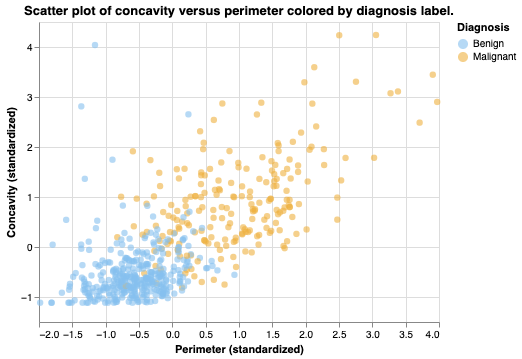

In [11]:
perim_concav

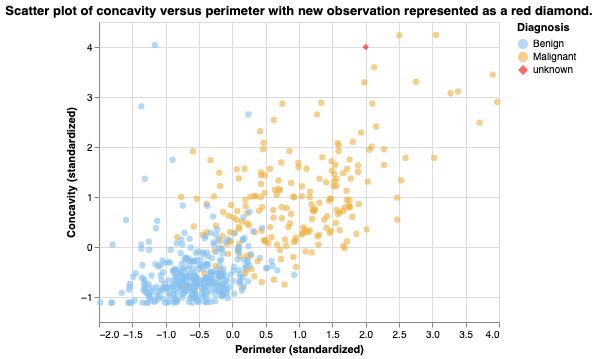

In [12]:
points_df = pd.DataFrame({
    'Perimeter': [2],
    'Concavity': [4],
    'Class': ['unknown']
})
perim_concav_with_new_point_df = pd.concat((cancer, points_df))

perim_concav_with_new_point = (
    alt.Chart(
        perim_concav_with_new_point_df,
        title="Scatter plot of concavity versus perimeter with new observation represented as a red diamond.",
    )
    .mark_point(opacity=0.6, filled=True, size=40)
    .encode(
        x=alt.X("Perimeter", title="Perimeter (standardized)"),
        y=alt.Y("Concavity", title="Concavity (standardized)"),
        color=alt.Color(
            "Class",
            scale=alt.Scale(range=["#86bfef", "#efb13f", "red"]),
            title="Diagnosis",
        ),
        shape=alt.Shape(
            "Class", scale=alt.Scale(range=["circle", "circle", "diamond"])
        ),
        # size=alt.Size('Class', scale=alt.Scale(range=[30, 30, 30]))
    )
)
perim_concav_with_new_point

Figure \@ref(fig:05-knn-2) shows that the nearest point to this new observation is **malignant** and
located at the coordinates (`r round(neighbors[1, c(attrs[1], attrs[2])],
1)`). The idea here is that if a point is close to another in the scatter plot,
then the perimeter and concavity values are similar, and so we may expect that
they would have the same diagnosis.

```{r 05-knn-2, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap="Scatter plot of concavity versus perimeter. The new observation is represented as a red diamond with a line to the one nearest neighbor, which has a malignant label."}
perim_concav_with_new_point +
  geom_segment(aes(
    x = new_point[1],
    y = new_point[2],
    xend = pull(neighbors[1, attrs[1]]),
    yend = pull(neighbors[1, attrs[2]])
  ), color = "black", size = 0.5)
```

```{r 05-knn-3, echo = FALSE}
new_point <- c(0.2, 3.3)
attrs <- c("Perimeter", "Concavity")
my_distances <- table_with_distances(cancer[, attrs], new_point)
neighbors <- cancer[order(my_distances$Distance), ]
```

Suppose we have another new observation with standardized perimeter `r new_point[1]` and
concavity of `r new_point[2]`. Looking at the scatter plot in Figure \@ref(fig:05-knn-4), how would you
classify this red, diamond observation? The nearest neighbor to this new point is a
**benign** observation at (`r round(neighbors[1, c(attrs[1], attrs[2])], 1)`).
Does this seem like the right prediction to make for this observation? Probably 
not, if you consider the other nearby points.

```{r 05-knn-4, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap="Scatter plot of concavity versus perimeter. The new observation is represented as a red diamond with a line to the one nearest neighbor, which has a benign label."}

perim_concav_with_new_point2 <- bind_rows(cancer, 
                                          tibble(Perimeter = new_point[1], 
                                                 Concavity = new_point[2], 
                                                 Class = "unknown")) |>
  ggplot(aes(x = Perimeter, 
             y = Concavity, 
             color = Class, 
             shape = Class, size = Class)) +
  geom_point(alpha = 0.6) +
  labs(color = "Diagnosis", 
       x = "Perimeter (standardized)", 
       y = "Concavity (standardized)") +
 scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18))+ 
  scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(2, 2, 2.5))
perim_concav_with_new_point2 +  
  geom_segment(aes(
    x = new_point[1],
    y = new_point[2],
    xend = pull(neighbors[1, attrs[1]]),
    yend = pull(neighbors[1, attrs[2]])
  ), color = "black", size = 0.5)
```

To improve the prediction we can consider several
neighboring points, say $K = 3$, that are closest to the new observation
to predict its diagnosis class. Among those 3 closest points, we use the
*majority class* as our prediction for the new observation. As shown in Figure \@ref(fig:05-knn-5), we
see that the diagnoses of 2 of the 3 nearest neighbors to our new observation
are malignant. Therefore we take majority vote and classify our new red, diamond
observation as malignant. 

```{r 05-knn-5, echo =  FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap="Scatter plot of concavity versus perimeter with three nearest neighbors."}
perim_concav_with_new_point2 + 
  geom_segment(aes(
    x = new_point[1], y = new_point[2],
    xend = pull(neighbors[1, attrs[1]]),
    yend = pull(neighbors[1, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = new_point[1], y = new_point[2],
    xend = pull(neighbors[2, attrs[1]]),
    yend = pull(neighbors[2, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = new_point[1], y = new_point[2],
    xend = pull(neighbors[3, attrs[1]]),
    yend = pull(neighbors[3, attrs[2]])
  ), color = "black", size = 0.5)
```

Here we chose the $K=3$ nearest observations, but there is nothing special
about $K=3$. We could have used $K=4, 5$ or more (though we may want to choose
an odd number to avoid ties). We will discuss more about choosing $K$ in the
next chapter. 

### Distance between points

We decide which points are the $K$ "nearest" to our new observation
using the *straight-line distance* (we will often just refer to this as *distance*). \index{distance!K-nearest neighbors}\index{straight line!distance}
Suppose we have two observations $a$ and $b$, each having two predictor variables, $x$ and $y$.
Denote $a_x$ and $a_y$ to be the values of variables $x$ and $y$ for observation $a$;
$b_x$ and $b_y$ have similar definitions for observation $b$.
Then the straight-line distance between observation $a$ and $b$ on the x-y plane can 
be computed using the following formula: 

$$\mathrm{Distance} = \sqrt{(a_x -b_x)^2 + (a_y - b_y)^2}$$
```{r 05-multiknn-0, echo = FALSE}
new_point <- c(0, 3.5)
```

To find the $K$ nearest neighbors to our new observation, we compute the distance
from that new observation to each observation in our training data, and select the $K$ observations corresponding to the
$K$ *smallest* distance values. For example, suppose we want to use $K=5$ neighbors to classify a new 
observation with perimeter of `r new_point[1]` and 
concavity of `r new_point[2]`, shown as a red diamond in Figure \@ref(fig:05-multiknn-1). Let's calculate the distances
between our new point and each of the observations in the training set to find
the $K=5$ neighbors that are nearest to our new point. 
You will see in the `mutate` \index{mutate} step below, we compute the straight-line
distance using the formula above: we square the differences between the two observations' perimeter 
and concavity coordinates, add the squared differences, and then take the square root.

```{r 05-multiknn-1, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.pos = "H", out.extra="", fig.cap="Scatter plot of concavity versus perimeter with new observation represented as a red diamond."}
perim_concav <- bind_rows(cancer, 
                          tibble(Perimeter = new_point[1], 
                                 Concavity = new_point[2], 
                                 Class = "unknown")) |>
  ggplot(aes(x = Perimeter, 
             y = Concavity, 
             color = Class, 
             shape = Class, 
             size = Class)) +
  geom_point(aes(x = new_point[1], 
                 y = new_point[2]), 
             color = "red", 
             size = 2.5, 
             pch = 18) + 
  geom_point(alpha = 0.5) +
  scale_x_continuous(name = "Perimeter (standardized)", 
                     breaks = seq(-2, 4, 1)) +
  scale_y_continuous(name = "Concavity (standardized)", 
                     breaks = seq(-2, 4, 1)) +
  labs(color = "Diagnosis") + 
  scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18))+ 
  scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(2, 2, 2.5))

perim_concav
```

```{r 05-multiknn-2}
new_obs_Perimeter <- 0
new_obs_Concavity <- 3.5
cancer |>
  select(ID, Perimeter, Concavity, Class) |>
  mutate(dist_from_new = sqrt((Perimeter - new_obs_Perimeter)^2 + 
                              (Concavity - new_obs_Concavity)^2)) |>
  arrange(dist_from_new) |>
  slice(1:5) # take the first 5 rows
```

In Table \@ref(tab:05-multiknn-mathtable) we show in mathematical detail how
the `mutate` step was used to compute the `dist_from_new` variable (the
distance to the new observation) for each of the 5 nearest neighbors in the
training data.

```{r 05-multiknn-4, echo = FALSE}
my_distances <- table_with_distances(cancer[, attrs], new_point)
neighbors <- my_distances[order(my_distances$Distance), ]
k <- 5
tab <- data.frame(neighbors[1:k, ], 
                  cancer[order(my_distances$Distance), ][1:k, c("ID", "Class")])


math_table <- tibble(Perimeter = round(tab[1:5,1],2), 
                     Concavity = round(tab[1:5,2],2), 
                          dist = round(neighbors[1:5, "Distance"], 2)
                    )
math_table <- math_table |> 
                    mutate(Distance = paste0("$\\sqrt{(", new_obs_Perimeter, " - ", ifelse(Perimeter < 0, "(", ""), Perimeter, ifelse(Perimeter < 0,")",""), ")^2",
                                             " + ",
                                             "(", new_obs_Concavity, " - ", ifelse(Concavity < 0,"(",""), Concavity, ifelse(Concavity < 0,")",""), ")^2} = ", dist, "$")) |>
                    select(-dist) |>
                    mutate(Class= tab[1:5, "Class"])
```

```{r 05-multiknn-mathtable, echo = FALSE}
kable(math_table, booktabs = TRUE, 
      caption = "Evaluating the distances from the new observation to each of its 5 nearest neighbors", 
      escape = FALSE) |>
  kable_styling(latex_options = "hold_position")
```

The result of this computation shows that 3 of the 5 nearest neighbors to our new observation are
malignant (`M`); since this is the majority, we classify our new observation as malignant. 
These 5 neighbors are circled in Figure \@ref(fig:05-multiknn-3).

```{r 05-multiknn-3, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap="Scatter plot of concavity versus perimeter with 5 nearest neighbors circled."}
perim_concav + annotate("path",
  x = new_point[1] + 1.4 * cos(seq(0, 2 * pi,
    length.out = 100
  )),
  y = new_point[2] + 1.4 * sin(seq(0, 2 * pi,
    length.out = 100
  ))
)
```

### More than two explanatory variables 

Although the above description is directed toward two predictor variables, 
exactly the same $K$-nearest neighbors algorithm applies when you
have a higher number of predictor variables.  Each predictor variable may give us new
information to help create our classifier.  The only difference is the formula
for the distance between points. Suppose we have $m$ predictor
variables for two observations $a$ and $b$, i.e., 
$a = (a_{1}, a_{2}, \dots, a_{m})$ and
$b = (b_{1}, b_{2}, \dots, b_{m})$.

The distance formula becomes \index{distance!more than two variables}

$$\mathrm{Distance} = \sqrt{(a_{1} -b_{1})^2 + (a_{2} - b_{2})^2 + \dots + (a_{m} - b_{m})^2}.$$

This formula still corresponds to a straight-line distance, just in a space
with more dimensions. Suppose we want to calculate the distance between a new
observation with a perimeter of 0, concavity of 3.5, and symmetry of 1, and
another observation with a perimeter, concavity, and symmetry of 0.417, 2.31, and
0.837 respectively. We have two observations with three predictor variables:
perimeter, concavity, and symmetry. Previously, when we had two variables, we
added up the squared difference between each of our (two) variables, and then
took the square root. Now we will do the same, except for our three variables.
We calculate the distance as follows

$$\mathrm{Distance} =\sqrt{(0 - 0.417)^2 + (3.5 - 2.31)^2 + (1 - 0.837)^2} = 1.27.$$

Let's calculate the distances between our new observation and each of the
observations in the training set to find the $K=5$ neighbors when we have these
three predictors. 
```{r}
new_obs_Perimeter <- 0
new_obs_Concavity <- 3.5
new_obs_Symmetry <- 1

cancer |>
  select(ID, Perimeter, Concavity, Symmetry, Class) |>
  mutate(dist_from_new = sqrt((Perimeter - new_obs_Perimeter)^2 + 
                              (Concavity - new_obs_Concavity)^2 +
                                (Symmetry - new_obs_Symmetry)^2)) |>
  arrange(dist_from_new) |>
  slice(1:5) # take the first 5 rows
```

Based on $K=5$ nearest neighbors with these three predictors we would classify the new observation as malignant since 4 out of 5 of the nearest neighbors are malignant class. 
Figure \@ref(fig:05-more) shows what the data look like when we visualize them 
as a 3-dimensional scatter with lines from the new observation to its five nearest neighbors.

```{r 05-more, echo = FALSE, message = FALSE, fig.cap = "3D scatter plot of the standardized symmetry, concavity, and perimeter variables. Note that in general we recommend against using 3D visualizations; here we show the data in 3D only to illustrate what higher dimensions and nearest neighbors look like, for learning purposes.", fig.retina=2, out.width="100%"}
attrs <- c("Perimeter", "Concavity", "Symmetry")

# create new scaled obs and get NNs
new_obs_3 <- tibble(Perimeter = 0, 
                    Concavity = 3.5, 
                    Symmetry = 1, 
                    Class = "Unknown")
my_distances_3 <- table_with_distances(cancer[, attrs], 
                                       new_obs_3[, attrs])
neighbors_3 <- cancer[order(my_distances_3$Distance), ]

data <- neighbors_3 |> select(Perimeter, Concavity, Symmetry) |> slice(1:5)

# add to the df
scaled_cancer_3 <- bind_rows(cancer, new_obs_3) |> 
  mutate(Class = fct_recode(Class, "Benign" = "B", "Malignant"= "M"))

plot_3d <- scaled_cancer_3 |>
  plot_ly() |>
  layout(scene = list(
    xaxis = list(title = "Perimeter", titlefont = list(size = 14)),
    yaxis = list(title = "Concavity", titlefont = list(size = 14)),
    zaxis = list(title = "Symmetry", titlefont = list(size = 14))
  )) |> 
  add_trace(x = ~Perimeter,
            y = ~Concavity,
            z = ~Symmetry,
            color = ~Class,
            opacity = 0.4,
            size = 2,
            colors = c("orange2", "steelblue2", "red"), 
            symbol = ~Class, symbols = c('circle','circle','diamond'))

x1 <- c(pull(new_obs_3[1]), data$Perimeter[1])
y1 <- c(pull(new_obs_3[2]), data$Concavity[1])
z1 <- c(pull(new_obs_3[3]), data$Symmetry[1])

x2 <- c(pull(new_obs_3[1]), data$Perimeter[2])
y2 <- c(pull(new_obs_3[2]), data$Concavity[2])
z2 <- c(pull(new_obs_3[3]), data$Symmetry[2])

x3 <- c(pull(new_obs_3[1]), data$Perimeter[3])
y3 <- c(pull(new_obs_3[2]), data$Concavity[3])
z3 <- c(pull(new_obs_3[3]), data$Symmetry[3])

x4 <- c(pull(new_obs_3[1]), data$Perimeter[4])
y4 <- c(pull(new_obs_3[2]), data$Concavity[4])
z4 <- c(pull(new_obs_3[3]), data$Symmetry[4])

x5 <- c(pull(new_obs_3[1]), data$Perimeter[5])
y5 <- c(pull(new_obs_3[2]), data$Concavity[5])
z5 <- c(pull(new_obs_3[3]), data$Symmetry[5])

plot_3d <- plot_3d  |>
  add_trace(x = x1, y = y1, z = z1, type = "scatter3d", mode = "lines", 
            name = "lines", showlegend = FALSE, color = I("steelblue2")) |>
  add_trace(x = x2, y = y2, z = z2, type = "scatter3d", mode = "lines", 
            name = "lines", showlegend = FALSE, color =  I("steelblue2")) |>
  add_trace(x = x3, y = y3, z = z3, type = "scatter3d", mode = "lines", 
            name = "lines", showlegend = FALSE, color =  I("steelblue2")) |>
  add_trace(x = x4, y = y4, z = z4, type = "scatter3d", mode = "lines", 
            name = "lines", showlegend = FALSE, color =  I("orange2")) |>
  add_trace(x = x5, y = y5, z = z5, type = "scatter3d", mode = "lines", 
            name = "lines", showlegend = FALSE, color =  I("steelblue2"))

if(!is_latex_output()){  
  plot_3d
} else {
  # scene = list(camera = list(eye = list(x=2, y=2, z = 1.5)))
  # plot_3d <- plot_3d  |> layout(scene = scene)
  # save_image(plot_3d, "img/plot3d_knn_classification.png", scale = 10)
  # cannot adjust size of points in this plot for pdf 
  # so using a screenshot for now instead
  knitr::include_graphics("img/plot3d_knn_classification.png")
}
```

### Summary of $K$-nearest neighbors algorithm

In order to classify a new observation using a $K$-nearest neighbor classifier, we have to do the following:

1. Compute the distance between the new observation and each observation in the training set.
2. Sort the data table in ascending order according to the distances.
3. Choose the top $K$ rows of the sorted table.
4. Classify the new observation based on a majority vote of the neighbor classes.

## $K$-nearest neighbors with `tidymodels`

Coding the $K$-nearest neighbors algorithm in R ourselves can get complicated,
especially if we want to handle multiple classes, more than two variables,
or predict the class for multiple new observations. Thankfully, in R,
the $K$-nearest neighbors algorithm is 
implemented in [the `parsnip` R package](https://parsnip.tidymodels.org/) [@parsnip] 
included in `tidymodels`, along with 
many [other models](https://www.tidymodels.org/find/parsnip/) \index{tidymodels}\index{parsnip}
 that you will encounter in this and future chapters of the book. The `tidymodels` collection
provides tools to help make and use models, such as classifiers.  Using the packages
in this collection will help keep our code simple, readable and accurate; the 
less we have to code ourselves, the fewer mistakes we will likely make. We 
start by loading `tidymodels`.

```{r 05-tidymodels, warning = FALSE, message = FALSE}
library(tidymodels)
```

Let's walk through how to use `tidymodels` to perform $K$-nearest neighbors classification. 
We will use the `cancer` data set from above, with
perimeter and concavity as predictors and $K = 5$ neighbors to build our classifier. Then
we will use the classifier to predict the diagnosis label for a new observation with
perimeter 0, concavity 3.5, and an unknown diagnosis label. Let's pick out our two desired
predictor variables and class label and store them as a new data set named `cancer_train`:

```{r 05-tidymodels-2}
cancer_train <- cancer |>
  select(Class, Perimeter, Concavity)
cancer_train
```

Next, we create a *model specification* for \index{tidymodels!model specification} $K$-nearest neighbors classification
by calling the `nearest_neighbor` function, specifying that we want to use $K = 5$ neighbors
(we will discuss how to choose $K$ in the next chapter) and the straight-line 
distance (`weight_func = "rectangular"`). The `weight_func` argument controls
how neighbors vote when classifying a new observation; by setting it to `"rectangular"`,
each of the $K$ nearest neighbors gets exactly 1 vote as described above. Other choices, 
which weigh each neighbor's vote differently, can be found on 
[the `parsnip` website](https://parsnip.tidymodels.org/reference/nearest_neighbor.html).
In the `set_engine` \index{tidymodels!engine} argument, we specify which package or system will be used for training
the model. Here `kknn` is the R package we will use for performing $K$-nearest neighbors classification.
Finally, we specify that this is a classification problem with the `set_mode` function.

```{r 05-tidymodels-3}
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec
```

In order to fit the model on the breast cancer data, we need to pass the model specification
and the data set to the `fit` function. We also need to specify what variables to use as predictors
and what variable to use as the target. Below, the `Class ~ Perimeter + Concavity` argument specifies 
that `Class` is the target variable (the one we want to predict),
and both `Perimeter` and `Concavity` are to be used as the predictors.

```{r 05-tidymodels-4}
knn_fit <- knn_spec |>
  fit(Class ~ Perimeter + Concavity, data = cancer_train)
```

We can also use a convenient shorthand syntax using a period, `Class ~ .`, to indicate
that we want to use every variable *except* `Class` \index{tidymodels!model formula} as a predictor in the model.
In this particular setup, since `Concavity` and `Perimeter` are the only two predictors in the `cancer_train`
data frame, `Class ~ Perimeter + Concavity` and `Class ~ .` are equivalent.
In general, you can choose individual predictors using the `+` symbol, or you can specify to
use *all* predictors using the `.` symbol.

```{r 05-tidymodels-4b, results = 'hide', echo = TRUE}
knn_fit <- knn_spec |>
  fit(Class ~ ., data = cancer_train)
knn_fit
```

```{r echo = FALSE}
print_tidymodels(knn_fit)
```

Here you can see the final trained model summary. It confirms that the computational engine used
to train the model  was `kknn::train.kknn`. It also shows the fraction of errors made by
the nearest neighbor model, but we will ignore this for now and discuss it in more detail
in the next chapter.
Finally, it shows (somewhat confusingly) that the "best" weight function 
was "rectangular" and "best" setting of $K$ was 5; but since we specified these earlier,
R is just repeating those settings to us here. In the next chapter, we will actually
let R find the value of $K$ for us. 

Finally, we make the prediction on the new observation by calling the `predict` \index{tidymodels!predict} function,
passing both the fit object we just created and the new observation itself. As above, 
when we ran the $K$-nearest neighbors
classification algorithm manually, the `knn_fit` object classifies the new observation as 
malignant ("M"). Note that the `predict` function outputs a data frame with a single 
variable named `.pred_class`.

```{r 05-predict}
new_obs <- tibble(Perimeter = 0, Concavity = 3.5)
predict(knn_fit, new_obs)
```

Is this predicted malignant label the true class for this observation? 
Well, we don't know because we do not have this
observation's diagnosis&mdash; that is what we were trying to predict! The 
classifier's prediction is not necessarily correct, but in the next chapter, we will 
learn ways to quantify how accurate we think our predictions are.

## Data preprocessing with `tidymodels`

### Centering and scaling

When using $K$-nearest neighbor classification, the *scale* \index{scaling} of each variable
(i.e., its size and range of values) matters. Since the classifier predicts
classes by identifying observations nearest to it, any variables with 
a large scale will have a much larger effect than variables with a small
scale. But just because a variable has a large scale *doesn't mean* that it is
more important for making accurate predictions. For example, suppose you have a
data set with two features, salary (in dollars) and years of education, and
you want to predict the corresponding type of job. When we compute the
neighbor distances, a difference of \$1000 is huge compared to a difference of
10 years of education. But for our conceptual understanding and answering of
the problem, it's the opposite; 10 years of education is huge compared to a
difference of \$1000 in yearly salary!

In many other predictive models, the *center* of each variable (e.g., its mean)
matters as well. For example, if we had a data set with a temperature variable
measured in degrees Kelvin, and the same data set with temperature measured in
degrees Celsius, the two variables would differ by a constant shift of 273
(even though they contain exactly the same information). Likewise, in our
hypothetical job classification example, we would likely see that the center of
the salary variable is in the tens of thousands, while the center of the years
of education variable is in the single digits. Although this doesn't affect the
$K$-nearest neighbor classification algorithm, this large shift can change the
outcome of using many other predictive models.  \index{centering}

To scale and center our data, we need to find
our variables' *mean* (the average, which quantifies the "central" value of a 
set of numbers) and *standard deviation* (a number quantifying how spread out values are). 
For each observed value of the variable, we subtract the mean (i.e., center the variable) 
and divide by the standard deviation (i.e., scale the variable). When we do this, the data 
is said to be *standardized*, \index{standardization!K-nearest neighbors} and all variables in a data set will have a mean of 0 
and a standard deviation of 1. To illustrate the effect that standardization can have on the $K$-nearest
neighbor algorithm, we will read in the original, unstandardized Wisconsin breast
cancer data set; we have been using a standardized version of the data set up
until now. To keep things simple, we will just use the `Area`, `Smoothness`, and `Class`
variables:

```{r 05-scaling-1, message = FALSE}
unscaled_cancer <- read_csv("data/unscaled_wdbc.csv") |>
  mutate(Class = as_factor(Class)) |>
  select(Class, Area, Smoothness)
unscaled_cancer
```

Looking at the unscaled and uncentered data above, you can see that the differences
between the values for area measurements are much larger than those for
smoothness. Will this affect
predictions? In order to find out, we will create a scatter plot of these two
predictors (colored by diagnosis) for both the unstandardized data we just
loaded, and the standardized version of that same data. But first, we need to
standardize the `unscaled_cancer` data set with `tidymodels`.

In the `tidymodels` framework, all data preprocessing happens 
using a `recipe` from [the `recipes` R package](https://recipes.tidymodels.org/) [@recipes]
Here we will initialize a recipe \index{recipe} \index{tidymodels!recipe|see{recipe}} for 
the `unscaled_cancer` data above, specifying
that the `Class` variable is the target, and all other variables are predictors:

```{r 05-scaling-2}
uc_recipe <- recipe(Class ~ ., data = unscaled_cancer)
print(uc_recipe)
```

So far, there is not much in the recipe; just a statement about the number of targets
and predictors. Let's add 
scaling (`step_scale`) \index{recipe!step\_scale} and 
centering (`step_center`) \index{recipe!step\_center} steps for 
all of the predictors so that they each have a mean of 0 and standard deviation of 1.
Note that `tidyverse` actually provides `step_normalize`, which does both centering and scaling in
a single recipe step; in this book we will keep `step_scale` and `step_center` separate
to emphasize conceptually that there are two steps happening. 
The `prep` function finalizes the recipe by using the data (here, `unscaled_cancer`)  \index{tidymodels!prep}\index{prep|see{tidymodels}}
to compute anything necessary to run the recipe (in this case, the column means and standard
deviations):

```{r 05-scaling-3}
uc_recipe <- uc_recipe |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()
uc_recipe
```

You can now see that the recipe includes a scaling and centering step for all predictor variables.
Note that when you add a step to a recipe, you must specify what columns to apply the step to.
Here we used the `all_predictors()` \index{recipe!all\_predictors} function to specify that each step should be applied to 
all predictor variables. However, there are a number of different arguments one could use here,
as well as naming particular columns with the same syntax as the `select` function. 
For example:

- `all_nominal()` and `all_numeric()`: specify all categorical or all numeric variables
- `all_predictors()` and `all_outcomes()`: specify all predictor or all target variables
- `Area, Smoothness`: specify both the `Area` and `Smoothness` variable
- `-Class`: specify everything except the `Class` variable

You can find a full set of all the steps and variable selection functions
on the [`recipes` reference page](https://recipes.tidymodels.org/reference/index.html).

At this point, we have calculated the required statistics based on the data input into the 
recipe, but the data are not yet scaled and centered. To actually scale and center 
the data, we need to apply the `bake` \index{tidymodels!bake} \index{bake|see{tidymodels}} function to the unscaled data.

```{r 05-scaling-4}
scaled_cancer <- bake(uc_recipe, unscaled_cancer)
scaled_cancer
```

It may seem redundant that we had to both `bake` *and* `prep` to scale and center the data.
 However, we do this in two steps so we can specify a different data set in the `bake` step if we want. 
 For example, we may want to specify new data that were not part of the training set. 

You may wonder why we are doing so much work just to center and
scale our variables. Can't we just manually scale and center the `Area` and
`Smoothness` variables ourselves before building our $K$-nearest neighbor model? Well,
technically *yes*; but doing so is error-prone.  In particular, we might
accidentally forget to apply the same centering / scaling when making
predictions, or accidentally apply a *different* centering / scaling than what
we used while training. Proper use of a `recipe` helps keep our code simple,
readable, and error-free. Furthermore, note that using `prep` and `bake` is
required only when you want to inspect the result of the preprocessing steps
yourself. You will see further on in Section
\@ref(puttingittogetherworkflow) that `tidymodels` provides tools to
automatically apply `prep` and `bake` as necessary without additional coding effort.

Figure \@ref(fig:05-scaling-plt) shows the two scatter plots side-by-side&mdash;one for `unscaled_cancer` and one for
`scaled_cancer`. Each has the same new observation annotated with its $K=3$ nearest neighbors.
In the original unstandardized data plot, you can see some odd choices
for the three nearest neighbors. In particular, the "neighbors" are visually
well within the cloud of benign observations, and the neighbors are all nearly
vertically aligned with the new observation (which is why it looks like there
is only one black line on this plot). Figure \@ref(fig:05-scaling-plt-zoomed)
shows a close-up of that region on the unstandardized plot. Here the computation of nearest
neighbors is dominated by the much larger-scale area variable. The plot for standardized data 
on the right in Figure \@ref(fig:05-scaling-plt) shows a much more intuitively reasonable
selection of nearest neighbors. Thus, standardizing the data can change things
in an important way when we are using predictive algorithms. 
Standardizing your data should be a part of the preprocessing you do
before predictive modeling and you should always think carefully about your problem domain and
whether you need to standardize your data. 

```{r 05-scaling-plt, echo = FALSE, fig.height = 4, fig.cap = "Comparison of K = 3 nearest neighbors with standardized and unstandardized data."}

attrs <- c("Area", "Smoothness")

# create a new obs and get its NNs
new_obs <- tibble(Area = 400, Smoothness = 0.135, Class = "unknown")
my_distances <- table_with_distances(unscaled_cancer[, attrs], 
                                     new_obs[, attrs])
neighbors <- unscaled_cancer[order(my_distances$Distance), ]

# add the new obs to the df
unscaled_cancer <- bind_rows(unscaled_cancer, new_obs)

# plot the scatter
unscaled <- ggplot(unscaled_cancer, aes(x = Area, 
                                        y = Smoothness, 
                                        group = Class, 
                                        color = Class, 
                                        shape = Class, size = Class)) +
  geom_point(alpha = 0.6) + 
  scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18)) +
    scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values=c(2,2,2.5)) + 
  ggtitle("Unstandardized Data") +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[1, attrs[1]]),
    yend = unlist(neighbors[1, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[2, attrs[1]]),
    yend = unlist(neighbors[2, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[3, attrs[1]]),
    yend = unlist(neighbors[3, attrs[2]])
  ), color = "black", size = 0.5)

# create new scaled obs and get NNs
new_obs_scaled <- tibble(Area = -0.72, Smoothness = 2.8, Class = "unknown")
my_distances_scaled <- table_with_distances(scaled_cancer[, attrs], 
                                            new_obs_scaled[, attrs])
neighbors_scaled <- scaled_cancer[order(my_distances_scaled$Distance), ]

# add to the df
scaled_cancer <- bind_rows(scaled_cancer, new_obs_scaled)

# plot the scatter
scaled <- ggplot(scaled_cancer, aes(x = Area, 
                                    y = Smoothness, 
                                    group = Class, 
                                    color = Class, 
                                    shape = Class, 
                                    size = Class)) +
  geom_point(alpha = 0.6) + 
  scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18)) +
  scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                    values=c(2,2,2.5)) + 
  ggtitle("Standardized Data") +
  labs(x = "Area (standardized)", y = "Smoothness (standardized)") + 
  # coord_equal(ratio = 1) +
  geom_segment(aes(
    x = unlist(new_obs_scaled[1]), y = unlist(new_obs_scaled[2]),
    xend = unlist(neighbors_scaled[1, attrs[1]]),
    yend = unlist(neighbors_scaled[1, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = unlist(new_obs_scaled[1]), y = unlist(new_obs_scaled[2]),
    xend = unlist(neighbors_scaled[2, attrs[1]]),
    yend = unlist(neighbors_scaled[2, attrs[2]])
  ), color = "black", size = 0.5) +
  geom_segment(aes(
    x = unlist(new_obs_scaled[1]), y = unlist(new_obs_scaled[2]),
    xend = unlist(neighbors_scaled[3, attrs[1]]),
    yend = unlist(neighbors_scaled[3, attrs[2]])
  ), color = "black", size = 0.5)

ggarrange(unscaled, scaled, ncol = 2, common.legend = TRUE, legend = "bottom")

```

```{r 05-scaling-plt-zoomed, fig.height = 4.5, fig.width = 9, echo = FALSE, fig.cap = "Close-up of three nearest neighbors for unstandardized data."}
library(ggforce)
ggplot(unscaled_cancer, aes(x = Area, 
                            y = Smoothness, 
                            group = Class, 
                            color = Class, 
                            shape = Class)) +
  geom_point(size = 2.5, alpha = 0.6) + 
  scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                   labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18)) +
    scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values = c(1, 1, 2.5)) + 
  ggtitle("Unstandardized Data") +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[1, attrs[1]]),
    yend = unlist(neighbors[1, attrs[2]])
  ), color = "black") +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[2, attrs[1]]),
    yend = unlist(neighbors[2, attrs[2]])
  ), color = "black") +
  geom_segment(aes(
    x = unlist(new_obs[1]), y = unlist(new_obs[2]),
    xend = unlist(neighbors[3, attrs[1]]),
    yend = unlist(neighbors[3, attrs[2]])
  ), color = "black") +  
   facet_zoom(x = ( Area > 380 & Area < 420) , 
              y = (Smoothness > 0.08 & Smoothness < 0.14), zoom.size = 2) + 
    theme_bw() + 
    theme(text = element_text(size = 18), axis.title=element_text(size=18), legend.position="bottom")
```

### Balancing

Another potential issue in a data set for a classifier is *class imbalance*, \index{balance}\index{imbalance}
i.e., when one label is much more common than another. Since classifiers like
the $K$-nearest neighbor algorithm use the labels of nearby points to predict
the label of a new point, if there are many more data points with one label
overall, the algorithm is more likely to pick that label in general (even if
the "pattern" of data suggests otherwise). Class imbalance is actually quite a
common and important problem: from rare disease diagnosis to malicious email
detection, there are many cases in which the "important" class to identify
(presence of disease, malicious email) is much rarer than the "unimportant"
class (no disease, normal email).

To better illustrate the problem, let's revisit the scaled breast cancer data, 
`cancer`; except now we will remove many of the observations of malignant tumors, simulating
what the data would look like if the cancer was rare. We will do this by
picking only 3 observations from the malignant group, and keeping all
of the benign observations. We choose these 3 observations using the `slice_head`
function, which takes two arguments: a data frame-like object,
and the number of rows to select from the top (`n`).
The new imbalanced data is shown in Figure \@ref(fig:05-unbalanced).

```{r 05-unbalanced-seed, echo = FALSE, fig.height = 3.5, fig.width = 4.5, warning = FALSE, message = FALSE}
# hidden seed here for reproducibility 
# randomness shouldn't affect much in this use of step_upsample,
# but just in case...
set.seed(3)
```

```{r 05-unbalanced, fig.height = 3.5, fig.width = 4.5, fig.pos = "H", out.extra="", fig.cap = "Imbalanced data."}
rare_cancer <- bind_rows(
      filter(cancer, Class == "B"),
      cancer |> filter(Class == "M") |> slice_head(n = 3)
    ) |>
    select(Class, Perimeter, Concavity)

rare_plot <- rare_cancer |>
  ggplot(aes(x = Perimeter, y = Concavity, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Perimeter (standardized)", 
       y = "Concavity (standardized)",
       color = "Diagnosis") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

rare_plot
```

Suppose we now decided to use $K = 7$ in $K$-nearest neighbor classification.
With only 3 observations of malignant tumors, the classifier 
will *always predict that the tumor is benign, no matter what its concavity and perimeter
are!* This is because in a majority vote of 7 observations, at most 3 will be
malignant (we only have 3 total malignant observations), so at least 4 must be
benign, and the benign vote will always win. For example, Figure \@ref(fig:05-upsample)
shows what happens for a new tumor observation that is quite close to three observations
in the training data that were tagged as malignant.

```{r 05-upsample, echo=FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap = "Imbalanced data with 7 nearest neighbors to a new observation highlighted."}
new_point <- c(2, 2)
attrs <- c("Perimeter", "Concavity")
my_distances <- table_with_distances(rare_cancer[, attrs], new_point)
my_distances <- bind_cols(my_distances, select(rare_cancer, Class))
neighbors <- rare_cancer[order(my_distances$Distance), ]


rare_plot <- bind_rows(rare_cancer, 
                       tibble(Perimeter = new_point[1], 
                              Concavity = new_point[2], 
                              Class = "unknown")) |>
  ggplot(aes(x = Perimeter, y = Concavity, color = Class, shape = Class)) +
  geom_point(alpha = 0.5) +
  labs(color = "Diagnosis", 
       x = "Perimeter (standardized)", 
       y = "Concavity (standardized)") + 
  scale_color_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"), 
                     values = c("steelblue2", "orange2", "red")) +
  scale_shape_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(16, 16, 18))+ 
  scale_size_manual(name = "Diagnosis", 
                     labels = c("Benign", "Malignant", "Unknown"),
                     values= c(2, 2, 2.5))

for (i in 1:7) {
  clr <- "steelblue2"
  if (neighbors$Class[i] == "M") {
    clr <- "orange2"
  }
  rare_plot <- rare_plot +
    geom_segment(
      x = new_point[1],
      y = new_point[2],
      xend = pull(neighbors[i, attrs[1]]),
      yend = pull(neighbors[i, attrs[2]]), color = clr
    )
}
rare_plot + geom_point(aes(x = new_point[1], y = new_point[2]),
  color = "red",
  size = 2.5,
  pch = 18
)
```

Figure \@ref(fig:05-upsample-2) shows what happens if we set the background color of 
each area of the plot to the predictions the $K$-nearest neighbor 
classifier would make. We can see that the decision is 
always "benign," corresponding to the blue color.

```{r 05-upsample-2, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.cap = "Imbalanced data with background color indicating the decision of the classifier and the points represent the labeled data."}

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- knn_spec |>
  fit(Class ~ ., data = rare_cancer)

# create a prediction pt grid
per_grid <- seq(min(rare_cancer$Perimeter), 
                max(rare_cancer$Perimeter), 
                length.out = 100)
con_grid <- seq(min(rare_cancer$Concavity), 
                max(rare_cancer$Concavity), 
                length.out = 100)
pcgrid <- as_tibble(expand.grid(Perimeter = per_grid, Concavity = con_grid))
knnPredGrid <- predict(knn_fit, pcgrid)
prediction_table <- bind_cols(knnPredGrid, pcgrid) |> 
  rename(Class = .pred_class)

# create the basic plt
rare_plot <-
  ggplot() +
  geom_point(data = rare_cancer, 
             mapping = aes(x = Perimeter, 
                           y = Concavity, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Perimeter, 
                           y = Concavity, 
                           color = Class), 
             alpha = 0.02, 
             size = 5.) +
  labs(color = "Diagnosis", 
       x = "Perimeter (standardized)", 
       y = "Concavity (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2"))

rare_plot
```

Despite the simplicity of the problem, solving it in a statistically sound manner is actually
fairly nuanced, and a careful treatment would require a lot more detail and mathematics than we will cover in this textbook.
For the present purposes, it will suffice to rebalance the data by *oversampling* the rare class. \index{oversampling}
In other words, we will replicate rare observations multiple times in our data set to give them more
voting power in the $K$-nearest neighbor algorithm. In order to do this, we will add an oversampling
step to the earlier `uc_recipe` recipe with the `step_upsample` function from the `themis` R package. \index{recipe!step\_upsample}
We show below how to do this, and also
use the `group_by` and `summarize` functions to see that our classes are now balanced:

```{r 05-upsample-cancer, warning = FALSE, message = FALSE}
library(themis)

ups_recipe <- recipe(Class ~ ., data = rare_cancer) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe
```

```{r 05-upsample-cancer-2}
upsampled_cancer <- bake(ups_recipe, rare_cancer)

upsampled_cancer |>
  group_by(Class) |>
  summarize(n = n())
```

Now suppose we train our $K$-nearest neighbor classifier with $K=7$ on this *balanced* data. 
Figure \@ref(fig:05-upsample-plot) shows what happens now when we set the background color 
of each area of our scatter plot to the decision the $K$-nearest neighbor 
classifier would make. We can see that the decision is more reasonable; when the points are close
to those labeled malignant, the classifier predicts a malignant tumor, and vice versa when they are 
closer to the benign tumor observations.

```{r 05-upsample-plot, echo = FALSE, fig.height = 3.5, fig.width = 4.5, fig.pos = "H", out.extra="", fig.cap = "Upsampled data with background color indicating the decision of the classifier."}
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- knn_spec |>
  fit(Class ~ ., data = upsampled_cancer)

# create a prediction pt grid
knnPredGrid <- predict(knn_fit, pcgrid)
prediction_table <- bind_cols(knnPredGrid, pcgrid) |> 
  rename(Class = .pred_class)

# create the basic plt
upsampled_plot <-
  ggplot() +
  geom_point(data = prediction_table, 
             mapping = aes(x = Perimeter, 
                           y = Concavity, 
                           color = Class), 
             alpha = 0.02, size = 5.) +
  geom_point(data = rare_cancer, 
             mapping = aes(x = Perimeter, 
                           y = Concavity, 
                           color = Class), 
             alpha = 0.75) +
  labs(color = "Diagnosis", 
       x = "Perimeter (standardized)", 
       y = "Concavity (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2"))

upsampled_plot
```

## Putting it together in a `workflow` {#puttingittogetherworkflow}

The `tidymodels` package collection also provides the `workflow`, a way to chain\index{tidymodels!workflow}\index{workflow|see{tidymodels}} together multiple data analysis steps without a lot of otherwise necessary code for intermediate steps.
To illustrate the whole pipeline, let's start from scratch with the `unscaled_wdbc.csv` data.
First we will load the data, create a model, and specify a recipe for how the data should be preprocessed:

```{r 05-workflow}
# load the unscaled cancer data 
# and make sure the target Class variable is a factor
unscaled_cancer <- read_csv("data/unscaled_wdbc.csv") |>
  mutate(Class = as_factor(Class))

# create the KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

# create the centering / scaling recipe
uc_recipe <- recipe(Class ~ Area + Smoothness, data = unscaled_cancer) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
```

Note that each of these steps is exactly the same as earlier, except for one major difference:
we did not use the `select` function to extract the relevant variables from the data frame,
and instead simply specified the relevant variables to use via the 
formula `Class ~ Area + Smoothness` (instead of `Class ~ .`) in the recipe.
You will also notice that we did not call `prep()` on the recipe; this is unnecessary when it is
placed in a workflow.

We will now place these steps in a `workflow` using the `add_recipe` and `add_model` functions, \index{tidymodels!add\_recipe}\index{tidymodels!add\_model}
and finally we will use the `fit` function to run the whole workflow on the `unscaled_cancer` data.
Note another difference from earlier here: we do not include a formula in the `fit` function. This \index{tidymodels!fit}
is again because we included the formula in the recipe, so there is no need to respecify it:

```{r 05-workflow-add, results = 'hide', echo = TRUE}
knn_fit <- workflow() |>
  add_recipe(uc_recipe) |>
  add_model(knn_spec) |>
  fit(data = unscaled_cancer)

knn_fit
```

```{r echo = FALSE}
print_tidymodels(knn_fit)
```

As before, the fit object lists the function that trains the model as well as the "best" settings
for the number of neighbors and weight function (for now, these are just the values we chose
 manually when we created `knn_spec` above). But now the fit object also includes information about
the overall workflow, including the centering and scaling preprocessing steps.
In other words, when we use the `predict` function with the `knn_fit` object to make a prediction for a new
observation, it will first apply the same recipe steps to the new observation. 
As an example, we will predict the class label of two new observations:
one with `Area = 500` and `Smoothness = 0.075`, and one with `Area = 1500` and `Smoothness = 0.1`.

```{r 05-workflow-predict}
new_observation <- tibble(Area = c(500, 1500), Smoothness = c(0.075, 0.1))
prediction <- predict(knn_fit, new_observation)

prediction
```

The classifier predicts that the first observation is benign ("B"), while the second is
malignant ("M"). Figure \@ref(fig:05-workflow-plot-show) visualizes the predictions that this 
trained $K$-nearest neighbor model will make on a large range of new observations.
Although you have seen colored prediction map visualizations like this a few times now,
we have not included the code to generate them, as it is a little bit complicated.
For the interested reader who wants a learning challenge, we now include it below. 
The basic idea is to create a grid of synthetic new observations using the `expand.grid` function, 
predict the label of each, and visualize the predictions with a colored scatter having a very high transparency 
(low `alpha` value) and large point radius. See if you can figure out what each line is doing!

> **Note:** Understanding this code is not required for the remainder of the
> textbook. It is included for those readers who would like to use similar
> visualizations in their own data analyses. 

```{r 05-workflow-plot-show, fig.height = 3.5, fig.width = 4.6, fig.cap = "Scatter plot of smoothness versus area where background color indicates the decision of the classifier."}
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(unscaled_cancer$Area), 
                max(unscaled_cancer$Area), 
                length.out = 100)
smo_grid <- seq(min(unscaled_cancer$Smoothness), 
                max(unscaled_cancer$Smoothness), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, 
                                Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = unscaled_cancer, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Area (standardized)", 
       y = "Smoothness (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot
```

## Exercises

Practice exercises for the material covered in this chapter 
can be found in the accompanying 
[worksheets repository](https://github.com/UBC-DSCI/data-science-a-first-intro-worksheets#readme)
in the "Classification I: training and predicting" row.
You can launch an interactive version of the worksheet in your browser by clicking the "launch binder" button.
You can also preview a non-interactive version of the worksheet by clicking "view worksheet."
If you instead decide to download the worksheet and run it on your own machine,
make sure to follow the instructions for computer setup
found in Chapter \@ref(move-to-your-own-machine). This will ensure that the automated feedback
and guidance that the worksheets provide will function as intended.